In [1]:

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import gc
from tensorflow import keras
from keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import os
# tf.keras.mixed_precision.set_global_policy("mixed_float16")
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from dataset import *
from modules import *
from pixel import *
from train import *
from predict import *


print(tf.config.list_physical_devices('GPU'))
LOAD_WEIGHTS = True
CHECKPOINT = './model_weights/new_weights'
PIXEL_CHECKPOINT = './CNNmodel_weights/pixel_weights'




c:\Users\jorda\miniconda3\envs\prac2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
train_np, test_np, train_imgs, test_imgs, train_variance = load_oasis()
        


Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.
<class 'numpy.ndarray'> (2416, 4, 256, 256, 1)
<class 'numpy.ndarray'> (544, 256, 256, 1)


In [3]:
latent_dim = 16
num_embeddings = 32

vqvae_trainer = VQVAETrainer(train_variance, latent_dim, num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

history = train_vqvae(vqvae_trainer, train_imgs, latent_dim=16, num_embeddings=32, num_epochs=30, 
                        CHECKPOINT='./model_weights/new_weights', LOAD_WEIGHTS=LOAD_WEIGHTS)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        1040      
                                                                 
Total params: 19,856
Trainable params: 19,856
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6

In [4]:
if not LOAD_WEIGHTS:
    plot_training(history)

1/1 [==============================] - 3s 3s/step


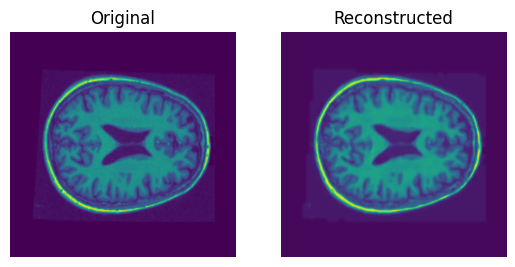

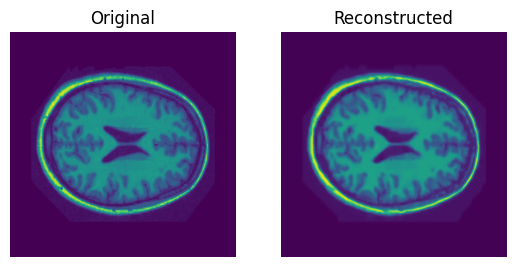

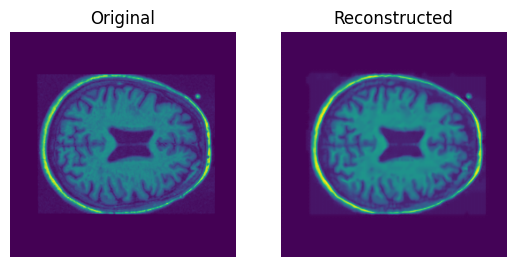

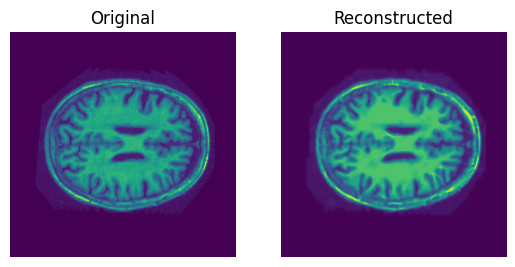

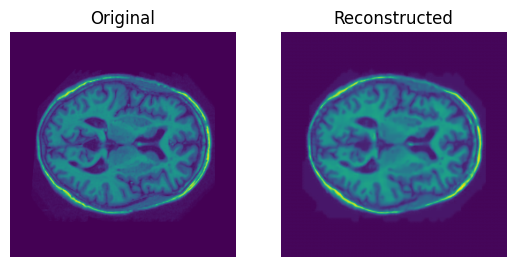

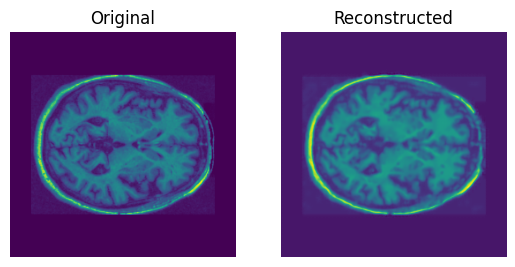

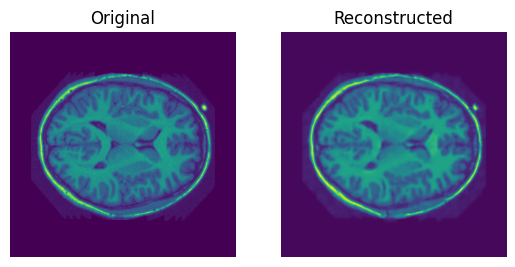

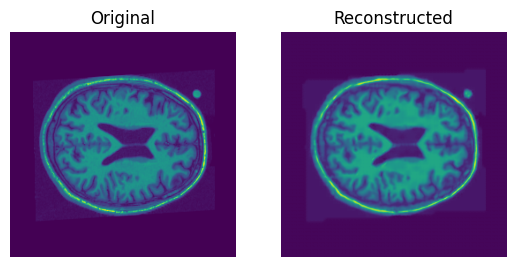

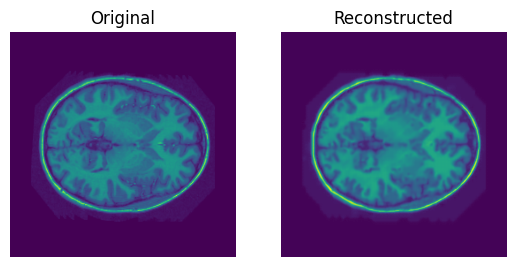

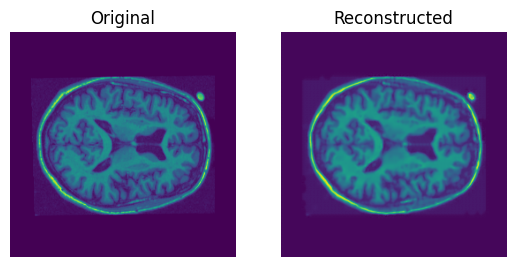

1/1 [==============================] - 0s 39ms/step


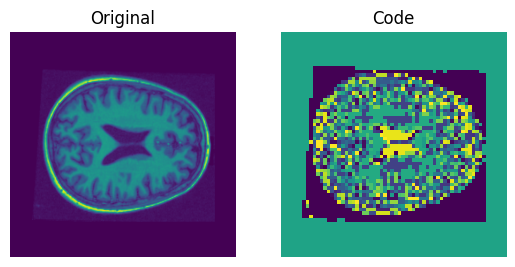

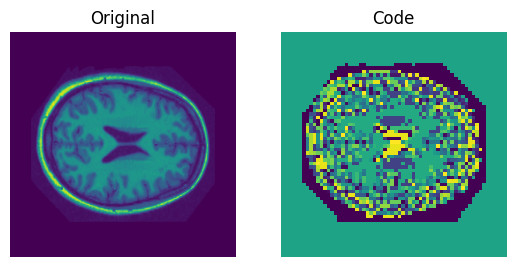

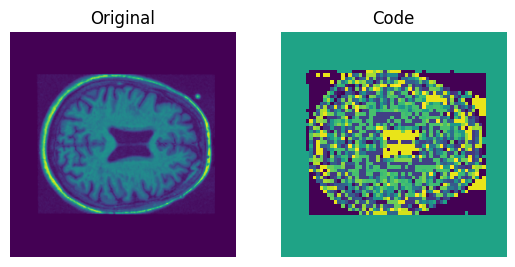

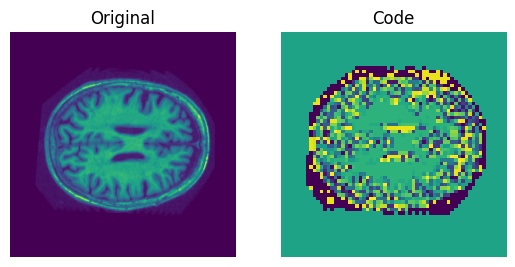

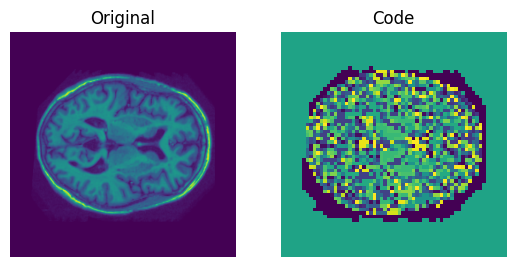

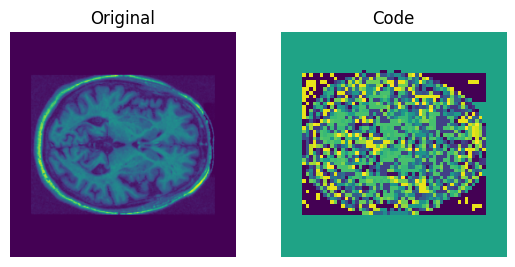

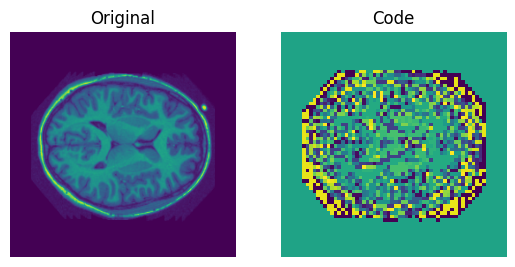

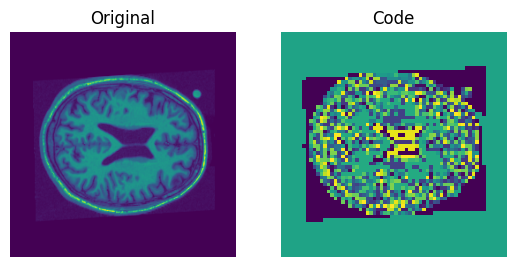

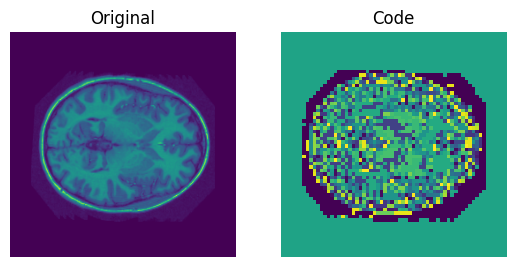

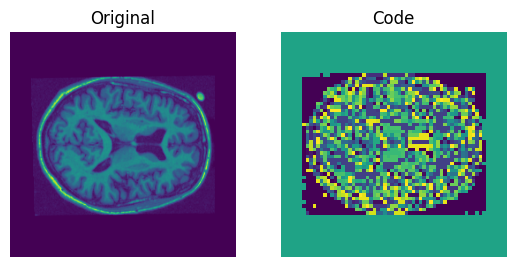

In [5]:
encoder_output_shape = reconstruct_oasis(vqvae_trainer, test_np)

Now that the Auto-Encoder has been trained and built, a CNN can be used to provide the generative aspect of the task. The process is:
- Pass images to the encoder
- Obtain the latent representation (encoding, using the VQ)
- Pass the encoded representation to the PixelCNN 
- Use the PixelCNN to generate a new encoded representation (training)
- Once trained, use the PixelCNN to generate encodings from random noise (?)




In [6]:
pixel_cnn = initialise_pixel(encoder_output_shape, vqvae_trainer)
pixel_cnn_model = pixel_cnn.model
codebook_indices = prepare_encodings(train_np, vqvae_trainer)
train_pixel(pixel_cnn_model, codebook_indices, 10)


Input shape of the PixelCNN: (64, 64)
1000/1000 [==============================] - 1s 1ms/step
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
Epoch 1/10
225/225 [==============================] - 8s 31ms/step - loss: 1.4537 - accuracy: 0.6257 - val_loss: 1.0665 - val_accuracy: 0.6754
Epoch 2/10
225/225 [==============================] - 7s 30ms/step - loss: 1.0189 - accuracy: 0.6827 - val_loss: 0.9852 - val_accuracy: 0.6892
Epoch 3/10
225/225 [==============================] - 7s 30ms/step - loss: 0.9592 - accuracy: 0.6936 - val_loss: 0.9400 - val_accuracy: 0.6977
Epoch 4/10
225/225 [==============================] - 7s 30ms/step - loss: 0.9238 - accuracy: 0.70

1/1 [==============================] - 0s 29ms/step
Prior shape: (10, 64, 64)
1/1 [==============================] - 0s 87ms/step


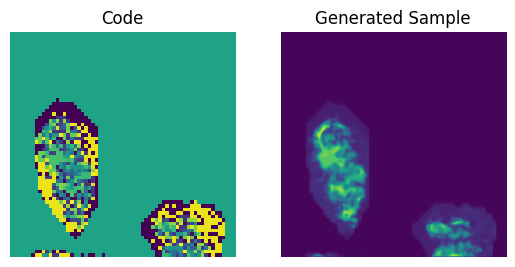

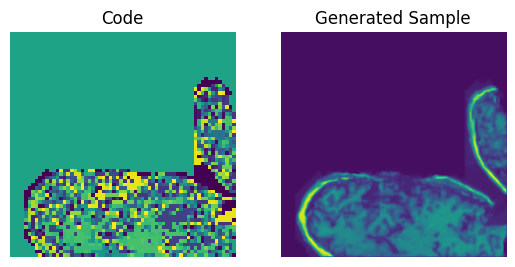

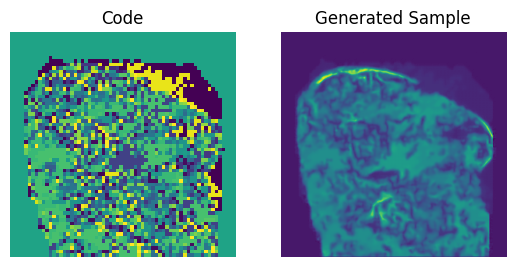

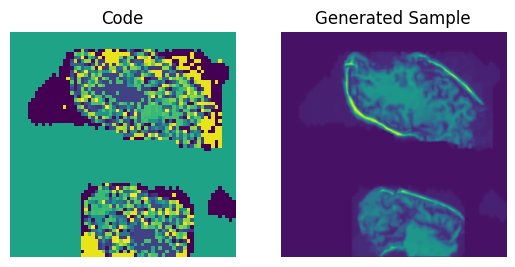

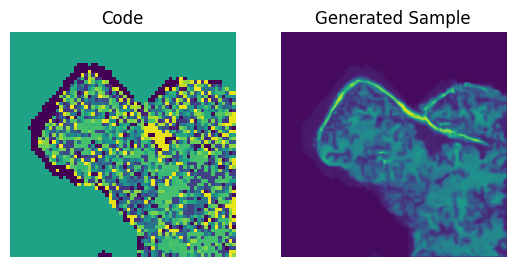

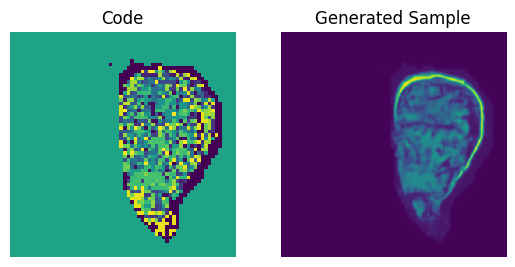

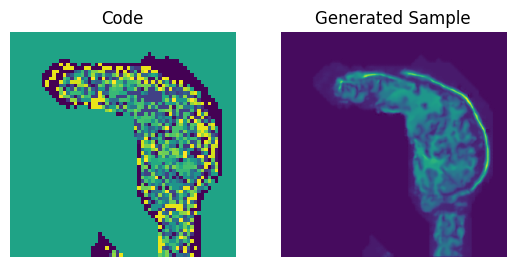

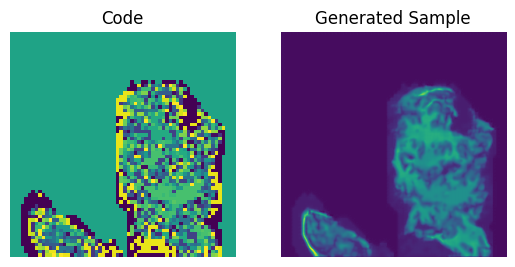

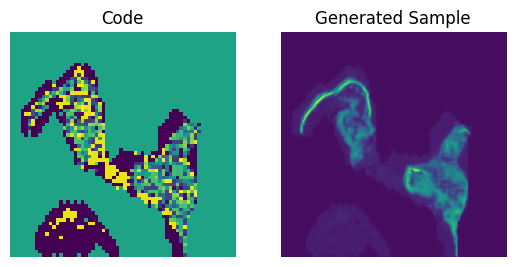

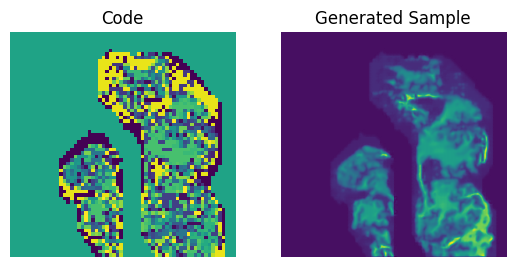

In [7]:
sampler_model = get_sampler(pixel_cnn_model)
priors = get_priors(pixel_cnn_model, sampler_model)
quantized_priors = quantize_priors(priors, vqvae_trainer, encoder_output_shape)
generator(vqvae_trainer, quantized_priors, priors)